In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import tqdm

plt.style.use('../ultrasurfaces_plotstyle.mplstyle')

from generator import (
    Response,
    OscPars,
    Generator,
    create_histogram,
)


### Plotting utility

In [2]:
def add_hist(fig, hist, label, **kwargs):
    # first and last bin are overflow bins in hist
    plt.stairs(hist['hist'][1:-1], hist['bin_edges'], label=label, **kwargs, lw=2.5)
    plt.stairs(
        hist['hist'][1:-1] + hist['hist_unc'][1:-1],
        hist['bin_edges'],
        baseline=hist['hist'][1:-1] - hist['hist_unc'][1:-1],
        fill=True,
        alpha=0.5,
        **kwargs
    )

### Set standard parameters

In [3]:
delta_msq_31 = 2.515e-3
sinsq_theta_23 = 0.565
# convert this to sin**2(2 \theta)
theta_23 = np.arcsin(np.sqrt(sinsq_theta_23))
sinsq_2theta_23 = np.sin(2 * theta_23)**2
default_pars = OscPars(delta_msq_31, sinsq_2theta_23)

default_response = Response(1., 0.05)

bin_edges = np.logspace(1., 2., 26)

## Check event generation

### Just playing around with a couple of histograms

In [4]:
gen = Generator(int(1e5), default_response, default_pars)
h0 = gen.get_histogram(bin_edges)

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.


In [5]:
gen_2 = Generator(int(1e5), default_response, OscPars(1.2 * default_pars.delta_mqs, default_pars.sinsq_2theta))
h2 = gen_2.get_histogram(bin_edges)

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.


In [6]:
gen_3 = Generator(int(1e5), Response(1.2 * default_response.mu, default_response.sigma), default_pars)
h3 = gen_3.get_histogram(bin_edges)

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.


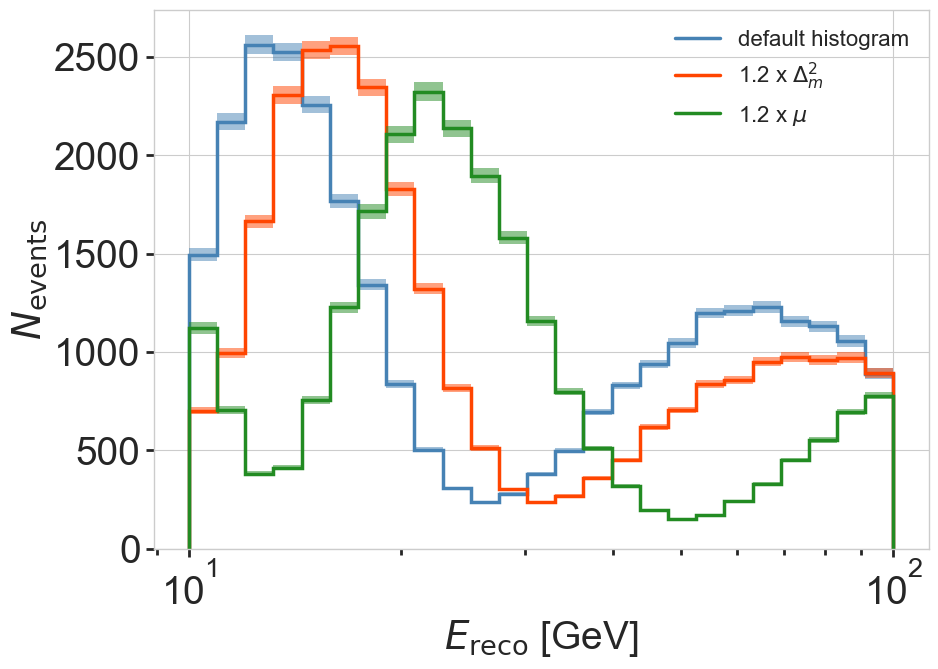

In [7]:
fig = plt.figure()

add_hist(fig, h0, r'default histogram', color='steelblue')

add_hist(fig, h2, r'1.2 x $\Delta_m^2$ ', color='orangered')

add_hist(fig, h3, r'1.2 x $\mu$', color='forestgreen')


plt.xscale('log')
plt.xlabel(r'$E_{\rm reco}$ [GeV]')
plt.ylabel(r'$N_{\rm events}$')

plt.legend()

## Toy analysis

### Define systematic sets by their detector response, assuming the default oscillation parameters for now

In [8]:
default_response = Response(1., 0.05)
nevents = int(1e4)

In [9]:
variations = {
    'mu': {
        'baseline': 1.,
        'up': 1.05,
        'low': 0.95,
    }
}

responses = {
    "mu_baseline": Response(variations['mu']['baseline'] * default_response.mu, default_response.sigma),
    "mu_up": Response(variations['mu']['up'] * default_response.mu, default_response.sigma),
    "mu_low": Response(variations['mu']['low'] * default_response.mu, default_response.sigma),
}

# assume default oscillation parameters for now
sets = {k: Generator(nevents, r, default_pars) for k,r in responses.items()}

print(variations)
print(sets)


Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.
Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.
Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.
{'mu': {'baseline': 1.0, 'up': 1.05, 'low': 0.95}}
{'mu_baseline': <generator.Generator object at 0x7fee25c89f40>, 'mu_up': <generator.Generator object at 0x7fee25c89a30>, 'mu_low': <generator.Generator object at 0x7fee25c89940>}


### Use the discrete sets, so far only gradients in $\mu$ are calculated for testing

In [10]:
class ToyAnalysis():

    def __init__(self, sets, variations, binning, baseline_key='mu_baseline') -> None:

        self.__sets = sets

        self.__baseline_key = baseline_key

        self.__binning = binning

        # pick one of the baseline sets
        self.__baseline_set = [s for k, s in sets.items() if "baseline" in k][0]

        self.__baseline_reponse = self.__baseline_set.get_detector_response()
        self.__default_pars = self.__baseline_set.get_oscillation_pars()

        self.__make_gradients(variations)

    def __make_gradients(self, variations):

        gradients_histogram = {}
        # naive way of calculating finite difference: G = (hist_up - hist_low) / delta_par
        # TODO: include statistical uncertainties?
        for par, vals in variations.items():
            
            hist_up = self.__sets[par+'_up'].get_histogram(self.__binning)['hist']
            hist_low = self.__sets[par+'_low'].get_histogram(self.__binning)['hist']
            delta_par = vals['up'] - vals['low']

            gradients_histogram[par] = (hist_up - hist_low) / delta_par

        self.__gradients = gradients_histogram

    def get_histogram(self, response, osc_pars):
        # reweight baseline set to oscillation parameters
        self.__baseline_set.reweight_oscillation(osc_pars)
        hist_base = self.__baseline_set.get_histogram(self.__binning)['hist']
        hist_base_unc = self.__baseline_set.get_histogram(self.__binning)['hist_unc']

        # not strictly necessary: re-set generator of baseline set to default oscillation pars
        self.__baseline_set.reweight_oscillation(self.__default_pars)

        # apply gradients:
        print("Warning: Only gradients with respect to 'mu' are implemeted so far")
        # TODO otherwise: loop over parameters...
        hist_final = hist_base + (response.mu - self.__baseline_reponse.mu) * self.__gradients['mu']

        # return histogram in full format (see Generator), statistical uncertainties from gradients not yet included...
        return {'hist': hist_final, 'hist_unc': hist_base_unc, 'bin_edges': self.__binning}

    def knn_prepare(self):
        # prepare knn
        self.X_nom = np.vstack((
            self.__sets[self.__baseline_key].get_events()["true_energy"],
            self.__sets[self.__baseline_key].get_events()["reco_energy"]
        )).T

        self.weights_nom = self.__sets[self.__baseline_key].get_events()["weights"]

        # only create tmp storage for systematics
        X_sys_tmp = [
            np.vstack((
                sys_set.get_events()["true_energy"],
                sys_set.get_events()["reco_energy"]
                )).T
            for sys_set_key, sys_set in self.__sets.items() if sys_set_key != self.__baseline_key
        ]

        weights_sys_tmp = np.hstack([
            sys_set.get_events()["weights"]
            for sys_set_key, sys_set in self.__sets.items() if sys_set_key != self.__baseline_key
        ])

        self.X = np.vstack([self.X_nom] + X_sys_tmp)
        self.weights = np.hstack([self.weights_nom] + [weights_sys_tmp])
        self.y = np.hstack(
            [
                np.full(len(self.__sets[self.__baseline_key].get_events()["true_energy"]), i)
                for i, _ in enumerate(self.__sets)
            ]
        )

    def knn_predict(self, knn_n_neighbors=1000, knn_weights="uniform"):
        # predict probabilities for nominal events and return them
        from sklearn import preprocessing
        from sklearn.neighbors import KNeighborsClassifier
        from sklearn.pipeline import Pipeline

        # a transformer to make all of the input data normal... classifiers like this
        self.__trafo = preprocessing.PowerTransformer(method='box-cox', standardize=True)

        # make these private later
        self.X_transformed = self.__trafo.fit_transform(self.X)

        self.__knn = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights)
        self.__pipe = Pipeline(
            [("transform", self.__trafo), ("classifier", self.__knn)]
        )
        self.__pipe.fit(self.X, self.y)


        self.__nominal_set_probabilities = self.__pipe.predict_proba(self.X_nom)

        return self.__nominal_set_probabilities

    def knn_fit_gradients(self, ):
        # interpolate knn predictions using the theil sen regressor so that the result is robust w.r.t. outliers
        from sklearn.linear_model import TheilSenRegressor
        from sklearn.preprocessing import PolynomialFeatures
        
        nom_events = self.__sets[self.__baseline_key].get_events()

        sigma_nom = self.__sets[self.__baseline_key].get_detector_response().sigma
        mu_nom = self.__sets[self.__baseline_key].get_detector_response().mu

        # the sigmas and mus for the systematic sets stay the same
        sigmas = np.array([
            sys_set.get_detector_response().sigma for sys_set_key, sys_set in self.__sets.items()
            ]) - sigma_nom
        mus = np.array([
            sys_set.get_detector_response().mu for sys_set_key, sys_set in self.__sets.items()
            ]) - mu_nom

        poly = PolynomialFeatures(2, include_bias=False, interaction_only=False)
        event_x = poly.fit_transform(np.vstack((mus, sigmas)).T)

        n_events = len(nom_events["weights"])
        self.__knn_gradients = np.zeros((n_events, event_x.shape[1]))

        # looping over many events in Python is super slow... but unfortunately there is no
        # version of the TheilSenRegressor that will make many different regressions at once
        for i, (true_e, reco_e) in (enumerate(zip(nom_events["true_energy"], nom_events["reco_energy"]))):

            pred_probs = self.__pipe.predict_proba(np.atleast_2d([true_e, reco_e]))[0]

            # divide out the nominal prob to get the re-scale ratio
            pred_probs = pred_probs / pred_probs[0]
            
            # because we fit without intercept, we must subtract the offset of 1!
            event_y = pred_probs - 1.
            reg = TheilSenRegressor(random_state=0, fit_intercept=False).fit(event_x, event_y)
            
            # extract the gradients from the estimator
            self.__knn_gradients[i] = reg.coef_

            # break
            
        return self.__knn_gradients



In [11]:
analysis = ToyAnalysis(sets, variations, bin_edges)

## Compare target histograms for generated set and gradient approximation:

### Default oscillation parameters

In [12]:
target_response = Response(1.05 * default_response.mu, default_response.sigma)
target_pars = OscPars(1. * default_pars.delta_mqs, default_pars.sinsq_2theta)

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.


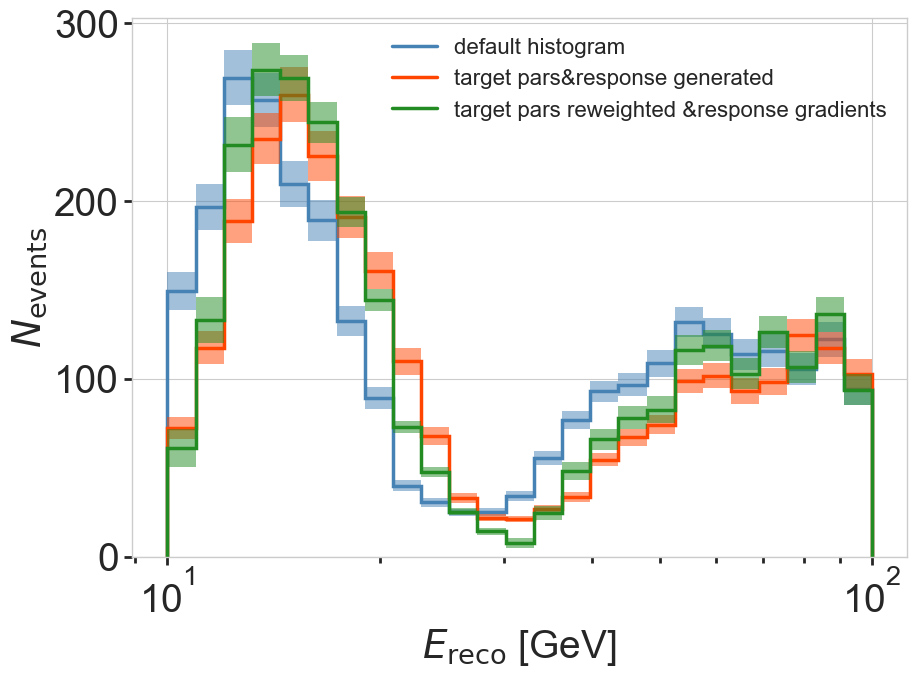

In [13]:
fig = plt.figure()

add_hist(fig, sets['mu_baseline'].get_histogram(bin_edges),
    'default histogram', color='steelblue')

add_hist(fig, Generator(nevents, target_response, target_pars).get_histogram(bin_edges),
    'target pars&response generated', color='orangered')

add_hist(fig, analysis.get_histogram(target_response, target_pars),
    'target pars reweighted &response gradients', color='forestgreen')


plt.xscale('log')
plt.xlabel(r'$E_{\rm reco}$ [GeV]')
plt.ylabel(r'$N_{\rm events}$')

plt.legend()

### Non-default oscillation parameters: larger mass splitting

In [14]:
target_response = Response(1.05 * default_response.mu, default_response.sigma)
target_pars = OscPars(1.3 * default_pars.delta_mqs, default_pars.sinsq_2theta)

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.


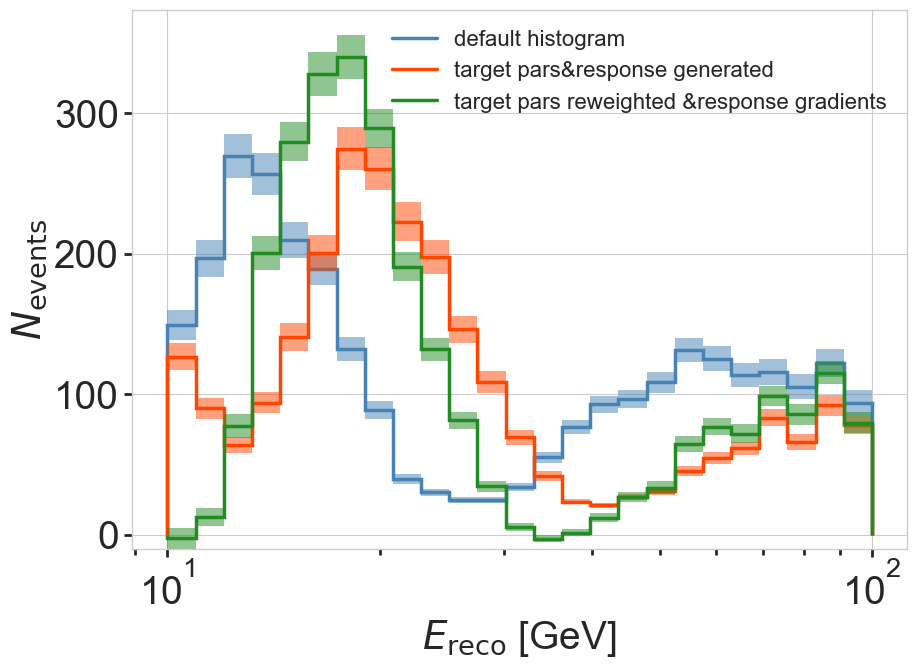

In [15]:
fig = plt.figure()

add_hist(fig, sets['mu_baseline'].get_histogram(bin_edges),
    'default histogram', color='steelblue')

add_hist(fig, Generator(nevents, target_response, target_pars).get_histogram(bin_edges),
    'target pars&response generated', color='orangered')

add_hist(fig, analysis.get_histogram(target_response, target_pars),
    'target pars reweighted &response gradients', color='forestgreen')


plt.xscale('log')
plt.xlabel(r'$E_{\rm reco}$ [GeV]')
plt.ylabel(r'$N_{\rm events}$')

plt.legend()

#### Set up/train/predict KNN

In [16]:
analysis.knn_prepare()

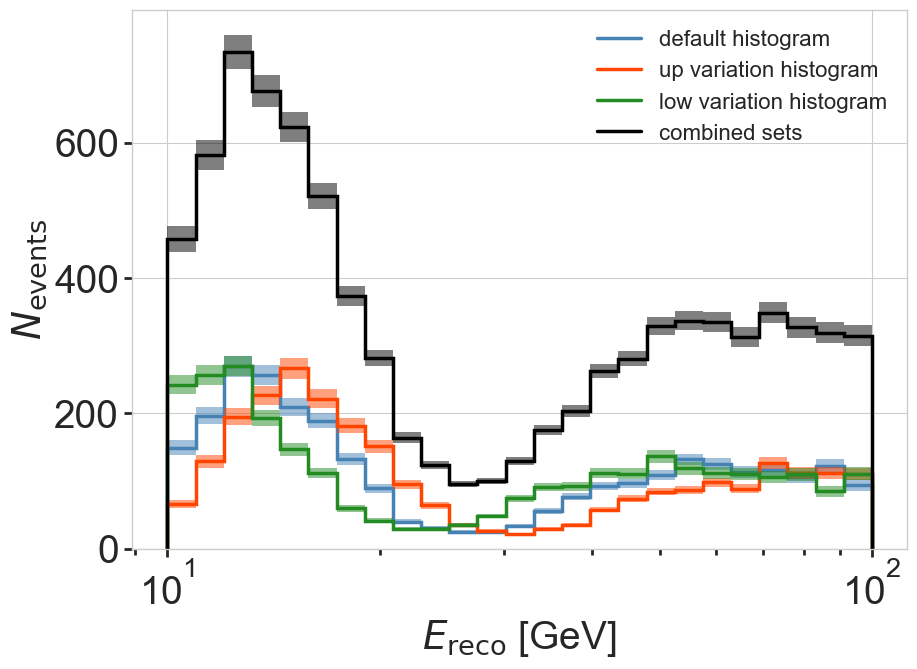

In [17]:
# look at the full reco data

fig = plt.figure()

add_hist(fig, sets['mu_baseline'].get_histogram(bin_edges),
    'default histogram', color='steelblue')

add_hist(fig, sets['mu_up'].get_histogram(bin_edges),
    'up variation histogram', color='orangered')

add_hist(fig, sets['mu_low'].get_histogram(bin_edges),
    'low variation histogram', color='forestgreen')

add_hist(fig, create_histogram(analysis.X [:,1], analysis.weights, bin_edges),
    'combined sets', color='k')

# # old
# add_hist(fig, create_histogram(X[:,1], weights, bin_edges),
#     'combined sets', color='k')

plt.xscale('log')
plt.xlabel(r'$E_{\rm reco}$ [GeV]')
plt.ylabel(r'$N_{\rm events}$')

plt.legend()

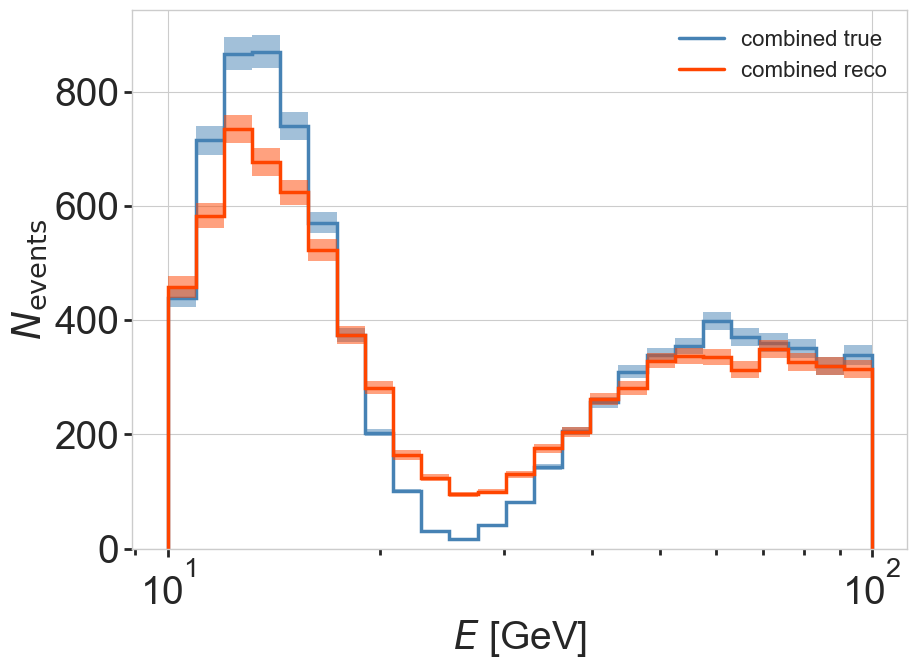

In [18]:
# look at reco/true data (fed into the classifier)

fig = plt.figure()

add_hist(fig, create_histogram(analysis.X[:,0], analysis.weights, bin_edges),
    'combined true', color='steelblue')

add_hist(fig, create_histogram(analysis.X[:,1], analysis.weights, bin_edges),
    'combined reco', color='orangered')

plt.xscale('log')
plt.xlabel(r'$E$ [GeV]')
plt.ylabel(r'$N_{\rm events}$')

plt.legend()

### Use predictions to re-weight nominal set

In [19]:
nominal_set_probabilities = analysis.knn_predict()

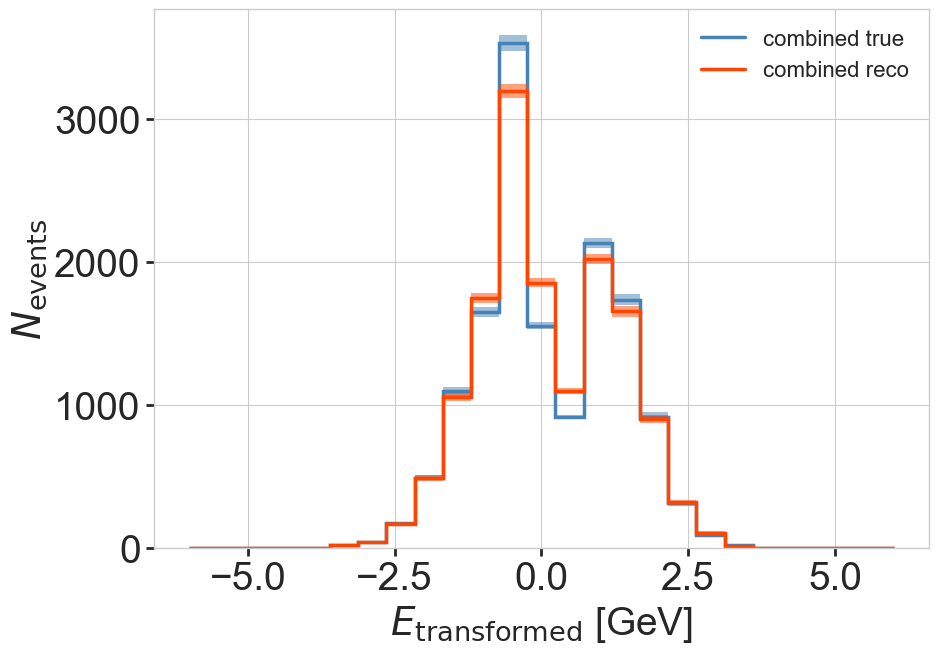

In [20]:
# look at transformed reco/true data (fed into the classifier)

fig = plt.figure()

bin_edges_transformed = np.linspace(-6., 6., 26)

add_hist(fig, create_histogram(analysis.X_transformed[:,0], analysis.weights, bin_edges_transformed),
    'combined true', color='steelblue')

add_hist(fig, create_histogram(analysis.X_transformed[:,1], analysis.weights, bin_edges_transformed),
    'combined reco', color='orangered')

# plt.xscale('log')
plt.xlabel(r'$E_{\rm transformed}$ [GeV]')
plt.ylabel(r'$N_{\rm events}$')

plt.legend()

In [21]:
# systematic set to be emulated
set_nr = 1

# calculate the denominator of the ratio
posterior_nominal = nominal_set_probabilities[:, 0]

# calculate the nominator
posterior_sys = nominal_set_probabilities[:, set_nr]

# adjust weights (but don't change the initial weights so we don't have to re-create the model)

weights_nom_KNN_rescaled = analysis.weights_nom * posterior_sys / posterior_nominal

In [22]:
target_response = Response(1.05 * default_response.mu, default_response.sigma)  # use "up" variation
target_pars = OscPars(1.2 * default_pars.delta_mqs, default_pars.sinsq_2theta)

print(target_response)
print(target_pars)

Response(mu=1.05, sigma=0.05)
OscPars(delta_mqs=0.003018, sinsq_2theta=0.9831000000000002)


Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0.


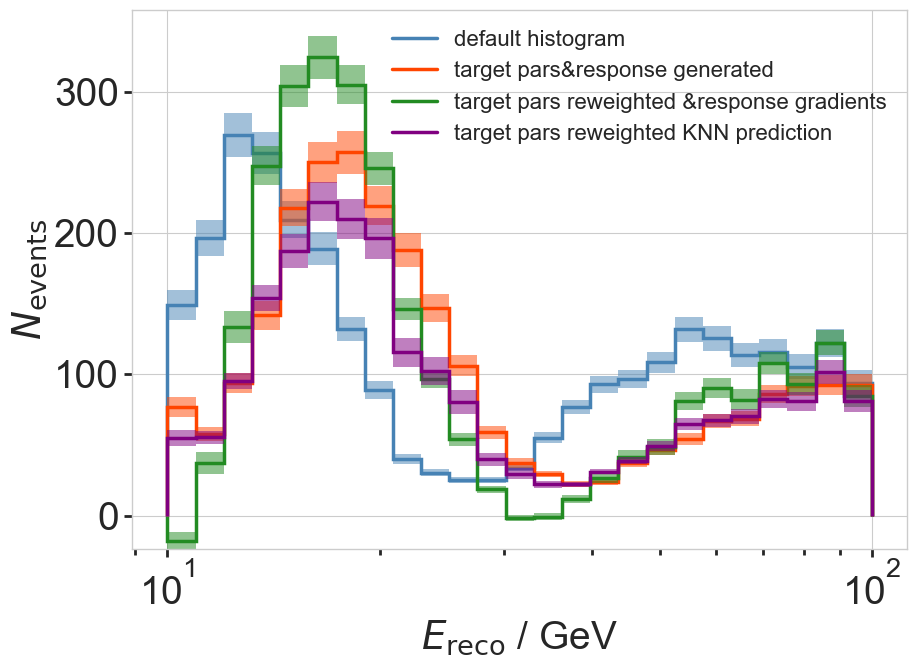

In [23]:
fig = plt.figure()

add_hist(fig, sets['mu_baseline'].get_histogram(bin_edges),
    'default histogram', color='steelblue')

add_hist(fig, Generator(nevents, target_response, target_pars).get_histogram(bin_edges),
    'target pars&response generated', color='orangered')

add_hist(fig, analysis.get_histogram(target_response, target_pars),
    'target pars reweighted &response gradients', color='forestgreen')

add_hist(fig, create_histogram(analysis.X_nom[:,1], weights_nom_KNN_rescaled * sets['mu_baseline'].get_oscillation_reweight_factor(target_pars), bin_edges),
    'target pars reweighted KNN prediction', color='purple')


plt.xscale('log')
plt.xlabel(r'$E_{\rm reco}$ / GeV')
plt.ylabel(r'$N_{\rm events}$')

plt.legend()

### Calculating gradients for all events

In [24]:
nominal_set_gradients = analysis.knn_fit_gradients()

In [41]:
# use them??!

The following cells aren't adapted, just copied over from the KNN notebook...

### Now use interpolated predictions to re-weight nominal set to any systematic parameters

In [40]:
# systematic set to be emulated
set_nr = 4

set_mu = sys_sets[set_nr - 1]["scale"]
set_sig = sys_sets[set_nr - 1]["shape"]

sigma_nom = nominal_set["shape"]
mu_nom = nominal_set["scale"]

delta_mu = set_mu - mu_nom
delta_sig = set_sig - sigma_nom

features = poly.fit_transform(np.atleast_2d([delta_mu, delta_sig]))[0]

# mu_grad = nominal_set["model"].events["grad_scale"]
# sig_grad = nominal_set["model"].events["grad_shape"]

gradients = nominal_set["model"].events["gradients"]

weight_factor = 1. + np.dot(gradients, features)

# adjust weights (but don't change the initial weights so we don't have to re-create the model)
nominal_set["model"].events["weights"] = (
    nominal_set["model"].events["initial_weights"] * weight_factor
)

NameError: name 'sys_sets' is not defined

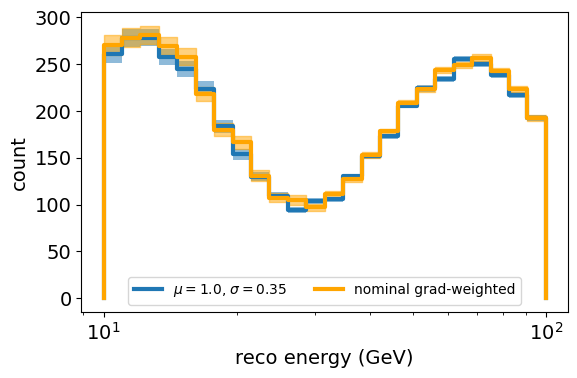

In [ ]:
fig = Figure(figsize=(6, 4))
ax = fig.get_ax()

plot_hist(
    ax=ax, hist=sys_sets[set_nr - 1]["model"].get_template(),
    label=fr"$\mu = {sys_sets[set_nr - 1]['scale']}$, $\sigma={sys_sets[set_nr - 1]['shape']}$",
    color=None,
    errors="band"
)

# adjust weights (but don't change the initial weights so we don't have to re-create the model)
nominal_set["model"].events["weights"] = (
    nominal_set["model"].events["initial_weights"] * weight_factor
)

plot_hist(
    ax=ax,
    hist=nominal_set["model"].get_template(),
    label="nominal grad-weighted",
    errors="band",
    # color=None
)



plt.legend(ncol=2, fontsize=10)
ax.set_xlabel("reco energy (GeV)")
ax.set_ylabel("count")
ax.set_xscale("log")
plt.tight_layout()
# plt.savefig("grad_weighted_sys_set_mu_1.1_sig_0.3.pdf")

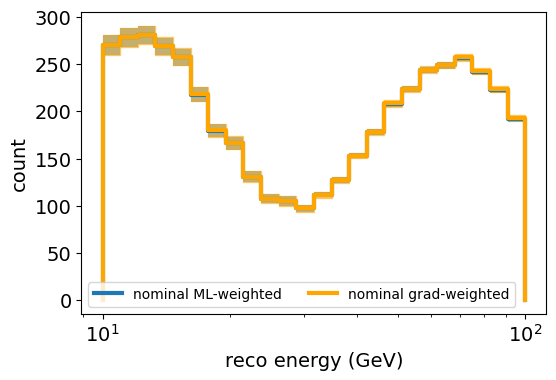

In [ ]:
# compare with direct ML re-weighting
fig = Figure(figsize=(6, 4))
ax = fig.get_ax()

# calculate the denominator of the ratio
posterior_nominal = nominal_set_probabilities[:, 0]
# calculate the nominator
posterior_sys = nominal_set_probabilities[:, set_nr]
# adjust weights (but don't change the initial weights so we don't have to re-create the model)
nominal_set["model"].events["weights"] = (
    nominal_set["model"].events["initial_weights"] * posterior_sys / posterior_nominal
)
plot_hist(
    ax=ax,
    hist=nominal_set["model"].get_template(),
    label="nominal ML-weighted",
    errors="band",
    color=None
)

# adjust weights (but don't change the initial weights so we don't have to re-create the model)
nominal_set["model"].events["weights"] = (
    nominal_set["model"].events["initial_weights"] * weight_factor
)
plot_hist(
    ax=ax,
    hist=nominal_set["model"].get_template(),
    label="nominal grad-weighted",
    errors="band",
    # color=None
)


plt.legend(ncol=2, fontsize=10)
ax.set_xlabel("reco energy (GeV)")
ax.set_ylabel("count")
ax.set_xscale("log")

#### Old stuff to manually set up the KNN (outsife of ToyAnalysis)

In [ ]:

# print(sets)
# print( [sys_set_key for sys_set_key, sys_set in sets.items() if sys_set_key != 'mu_baseline'] )


# # ported into ToyAnalysis class
# X_nom = np.vstack((
#     sets['mu_baseline'].get_events()["true_energy"],
#     sets['mu_baseline'].get_events()["reco_energy"]
# )).T

# weights_nom = sets['mu_baseline'].get_events()["weights"]

# X_sys = [
#     np.vstack((sys_set.get_events()["true_energy"],
#                sys_set.get_events()["reco_energy"]
#               )).T
#     for sys_set_key, sys_set in sets.items() if sys_set_key != 'mu_baseline'
# ]

# weights_sys = np.hstack([
#     sys_set.get_events()["weights"]
#     for sys_set_key, sys_set in sets.items() if sys_set_key != 'mu_baseline'
# ])

# X = np.vstack([X_nom] + X_sys)

# weights = np.hstack([weights_nom] + [weights_sys])

# y = np.hstack(
#     [
#         np.full(len(sets['mu_baseline'].get_events()["true_energy"]), i)
#         for i, _ in enumerate(sets)
#     ]
# )

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn import preprocessing
# from sklearn.pipeline import Pipeline

# # a transformer to make all of the input data normal... classifiers like this
# trafo = preprocessing.PowerTransformer(method='box-cox', standardize=True)

In [ ]:
# X_transformed = trafo.fit_transform(X)

In [ ]:
# knn = KNeighborsClassifier(n_neighbors=1000, weights="uniform")
# pipe = Pipeline(
#     [("transform", trafo), ("classifier", knn)]
# )
# pipe.fit(X, y)

Pipeline(steps=[('transform', PowerTransformer(method='box-cox')),
                ('classifier', KNeighborsClassifier(n_neighbors=1000))])

In [ ]:
# # using the theil sen regressor so that the result is robust w.r.t. outliers
# from sklearn.linear_model import TheilSenRegressor
# from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# nom_events = sets['mu_baseline'].get_events()

# sigma_nom = sets['mu_baseline'].get_detector_response().sigma
# mu_nom = sets['mu_baseline'].get_detector_response().mu

# # the sigmas and mus for the systematic sets stay the same
# sigmas = np.array([sys_set.get_detector_response().sigma for sys_set_key, sys_set in sets.items()]) - sigma_nom
# mus = np.array([sys_set.get_detector_response().mu for sys_set_key, sys_set in sets.items()]) - mu_nom

# poly = PolynomialFeatures(2, include_bias=False, interaction_only=False)
# event_x = poly.fit_transform(np.vstack((mus, sigmas)).T)

# n_events = len(nom_events["weights"])
# nom_events["gradients"] = np.zeros((n_events, event_x.shape[1]))

# # looping over many events in Python is super slow... but unfortunately there is no
# # version of the TheilSenRegressor that will make many different regressions at once
# for i, (true_e, reco_e) in (enumerate(zip(nom_events["true_energy"], nom_events["reco_energy"]))):
#     pred_probs = pipe.predict_proba(np.atleast_2d([true_e, reco_e]))[0]
#     # divide out the nominal prob to get the re-scale ratio
#     pred_probs = pred_probs / pred_probs[0]
    
#     # because we fit without intercept, we must subtract the offset of 1!
#     event_y = pred_probs - 1.
#     reg = TheilSenRegressor(random_state=0, fit_intercept=False).fit(event_x, event_y)
    
#     # extract the gradients from the estimator
#     nom_events["gradients"][i] = reg.coef_

#     # break